In [6]:
# move to the folder with dataset
from google.colab import drive
drive.mount('/content/gdrive')
%cd /content/gdrive/My Drive/Deep_Learning/toyota_model_recognition

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/My Drive/Deep_Learning/toyota_model_recognition


In [2]:
#pip install split-folders

In [3]:
#  details on usage here: https://github.com/jfilter/split-folders
# import split folders in order to split the images folders into train and validation
#import splitfolders

# the dataset is balanced so we use the ration for spliting
# the data is split into only train and validation sets
# splitfolders.ratio("images", output = "output", seed = 42, ratio = (0.91, 0.09))

Copying files: 1100 files [07:33,  2.42 files/s]


In [4]:
# Import dependencies
from keras.layers import Input, Lambda, Dense, Flatten, Dropout, BatchNormalization
from keras.models import Model, load_model
from keras.applications.vgg19 import VGG19
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
import numpy as np
from glob import glob
import matplotlib.pyplot as plt

In [5]:
# re-size all the images to this
image_size = [224, 224]

# load the data
train_data_path = './output/train'
val_data_path = './output/val'

In [6]:
# add preprocessing layer to the front of VGG
vgg_19 = VGG19(input_shape = image_size + [3], weights='imagenet', include_top=False)

80150528/80134624 [==============================] - 1s 0us/step


In [7]:
# don't train existing weights
for layer in vgg_19.layers:
  layer.trainable = False

In [8]:
# useful for getting number of classes
folders = glob('./output/train/*')
folders

['./output/train/toyota_sienna',
 './output/train/toyota_hilux',
 './output/train/toyota_avalon',
 './output/train/toyota_camry',
 './output/train/toyota_hiace',
 './output/train/toyota_landcruiser',
 './output/train/toyota_4runner',
 './output/train/toyota_corolla',
 './output/train/toyota_fjcruiser',
 './output/train/toyota_rav4']

In [9]:
# our layers
vgg19 = Flatten()(vgg_19.output) # flattens the last layer

# three hidden fully connected layers with dropouts and batch normalization
vgg19 = Dense(1024, activation='relu')(vgg19)
vgg19 = BatchNormalization()(vgg19)
vgg19 = Dropout(0.2)(vgg19)

# specify the output layer with 10 classes
prediction = Dense(len(folders), activation='softmax')(vgg19)

In [10]:
# create a model object
model = Model(inputs=vgg_19.input, outputs=prediction)

# view the structure of the model
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [11]:
# compile the model, tell it what cost and optimization method to use
model.compile(optimizer=Adam(learning_rate=0.00001), loss='categorical_crossentropy', metrics=['accuracy'])
 
model_path = 'model_dir/model.h5'
callbacks = [ModelCheckpoint(model_path, monitor='val_accuracy', verbose=1, save_best_only=True)]

In [12]:
# generate the images
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)

training_set = train_datagen.flow_from_directory('./output/train',
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

test_set = test_datagen.flow_from_directory('./output/val',
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'categorical')

Found 1000 images belonging to 10 classes.
Found 100 images belonging to 10 classes.


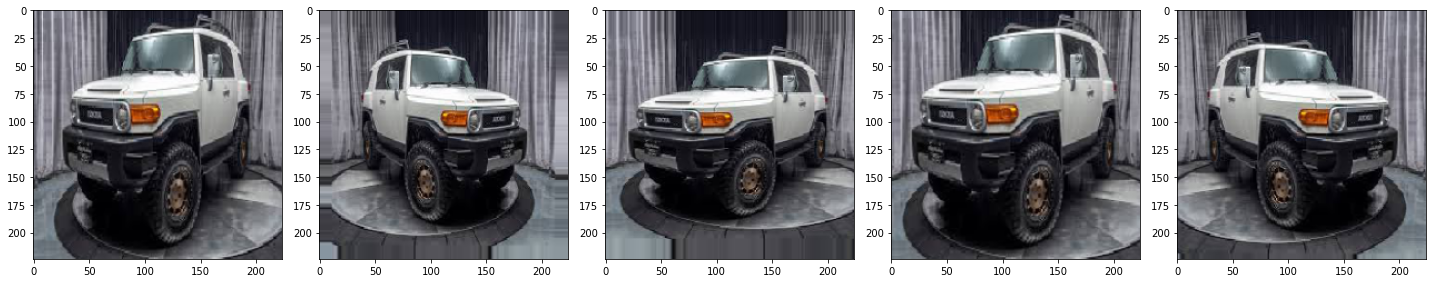

In [13]:
# define a function to plot images
def plotImages(images_arr):
  fig, axes = plt.subplots(1, 5, figsize=(20, 20))
  axes = axes.flatten()
  for img, ax in zip(images_arr, axes):
    ax.imshow(img)
  plt.tight_layout()
  plt.show()

images = [training_set[0][0][0] for i in range(5)]

plotImages(images)

In [ ]:
# fit the model
history = model.fit_generator(training_set,
                              validation_data=test_set,
                              epochs=200,
                              steps_per_epoch=len(training_set),
                              validation_steps=len(test_set),
                              callbacks=callbacks
                              )

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1915: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/200
 5/32 [===>..........................] - ETA: 8:12 - loss: 2.9629 - accuracy: 0.0811

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


32/32 [==============================] - 647s 20s/step - loss: 2.7932 - accuracy: 0.1146 - val_loss: 2.3490 - val_accuracy: 0.1700

Epoch 00001: val_accuracy improved from -inf to 0.17000, saving model to model_dir/model.h5
Epoch 2/200
10/32 [========>.....................] - ETA: 6:45 - loss: 2.2688 - accuracy: 0.2545

In [ ]:
# plot the model losses
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.show()

# plot the model accuracies
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()

In [ ]:
# load the saved model
model_loaded = load_model(model_path)

In [ ]:
import numpy as np
from keras.preprocessing import image
 
def pred_toyota_model(model, imagefile):
    test_image = image.load_img(imagefile, target_size = (224, 224))
    test_image = image.img_to_array(test_image)/255
    print("Shape Before {}".format(test_image.shape))
    test_image = np.expand_dims(test_image, axis = 0)
    print("Shape After {}".format(test_image.shape))
 
    result = model_loaded.predict(test_image).round(3)
 
    pred = np.argmax(result)
    print(result, "--->>>", pred)
    
    predict = {0: 'Toyota 4runner', 1: 'Toyota Avalon', 2: 'Toyota_Camry', 3: 'Toyota Corolla', 4: 'Toyota FJCruiser', 5: 'Toyota Hiace',
    6: 'Toyota Hilux', 7: 'Toyota LandCruiser', 8: 'Toyota Rav4', 9: 'Toyota Sienna'}
  
    return 'The Car Model Is {}!'.format(predict.get(pred))

In [ ]:
pred_toyota_model(model_loaded, './output/train/toyota_avalon/0c3b2d1706.jpg')